In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import os
from matplotlib import rc
import sklearn
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

In [95]:
rc('text', usetex=True)
rc('font', family='sans-serif')

In [294]:
numBlocks = 9

In [274]:
def load(filepath):
    df = pd.read_csv(filepath)
    df.drop(columns=['space_bar.keys', 'space_bar.rt', 'participant', 'session', 'date', 'expName',
                    'psychopyVersion', 'OS', 'frameRate', 'steps.thisRepN', 'steps.thisTrialN',
                    'steps.thisIndex', 'steps.ran', 'blocks.thisRepN', 'blocks.thisTrialN', 'blocks.thisN',
                    'blocks.thisIndex', 'blocks.ran'], inplace=True)
    df.dropna(how='all', inplace=True)
    df.reset_index(inplace=True)
    df.drop(columns = 'index', inplace=True)
    df["commit"] = [1 if resp == 'up' or resp == 'down' else 0 for resp in df['resp.keys']]
    df["resp.keys"] = [1 if resp == 'up' else -1 if resp == 'down' else 0 for resp in df['resp.keys']]
    return df

In [50]:
def convert_to_bursty(choice, idx):
    '''Converts simulated choice data structure into a data structure of time lags (amount of time since last
    consuming a particular choice).
    
    Parameters
    ----------
    choice : numpy array
        The data structure containing the choice made for each time point t in the simulation.
        
    Returns
    -------
    lags : pandas DataFrame
        The DataFrame containing the time lags for choice 2 (choice_index = 1 denotes choice 2, = 0 
        denotes choice 1)
    dfTL.shape[0] : int
        The number of lags in the DataFrame
    
    '''
    choice_index = 1 - idx
    new_choice = [float(i) for i in choice]
    new_choice = [float('nan') if x==choice_index else x for x in new_choice]
    choicetime = []
    for i in range(0,len(new_choice)):
        if round(new_choice[i],1) == idx: # choice == 0 if event happen (e.g., go to gym)
            choicetime.append(i)
    time_lags = [choicetime[i] - choicetime[i-1] for i in range(1,len(choicetime))]
    dfTL = pd.DataFrame(time_lags, columns=['TL'])
    dfTL['counts'] = choicetime[0:len(choicetime)-1]
    lags = dfTL.groupby(dfTL['TL']).count()
    return np.array(time_lags), np.array(lags.index), np.array(lags.counts), dfTL.shape[0]

In [293]:
def compute_burstiness(lags_line):
    mean = np.mean(lags_line)
    std = np.std(lags_line)
    return (std - mean)/(std+mean)

def plot_bursty(data):
    q = []; eps = []; b_i = [];
    fig, ax = plt.subplots(figsize=(5,2.5),dpi=150)
    plt.subplots_adjust(wspace=0.1)
    for i in range(1,numBlocks+1):
        curBlock = block(i,data)
        all_lags, lags, freq, N = convert_to_bursty(np.array(curBlock.commit), 1)
        q.append(curBlock['q_prob'].iloc[1]); eps.append(curBlock['eps_prob'].iloc[1])
        b_i.append(compute_burstiness(all_lags))
        
    q = np.array(q); q = q.reshape(-1,1)
    eps = np.array(eps); eps = eps.reshape(-1,1)
    b_i = np.array(b_i); b_i = b_i.reshape(-1,1)
    plt.subplot(121)
    plt.scatter(q,b_i)
    plt.xlabel('$q$'); plt.ylabel('$B$')
    q_mdl = LinearRegression(); q_mdl.fit(q,b_i)
    plt.plot(q, q_mdl.predict(q), 'r')
    
    plt.subplot(122)
    plt.scatter(eps,b_i)
    plt.xlabel('$\epsilon$'); plt.yticks([])
    eps_mdl = LinearRegression(); eps_mdl.fit(eps,b_i)
    plt.plot(eps, eps_mdl.predict(eps), 'r')
    plt.show()
    
def get_threshold(data):
    q = []; eps = []; up_price = []; down_price = [];
    fig, ax = plt.subplots(figsize=(6,3.5),dpi=150)
    plt.subplots_adjust(wspace=0.3)
    for i in range(1,numBlocks+1):
        curBlock = block(i,data)
        ups = curBlock.index[curBlock['resp.keys'] == 1]
        ups = ups - 1
        ups = ups[1:]
        downs = curBlock.index[curBlock['resp.keys'] == -1]
        downs = downs - 1
        downs = downs[1:]
        q.append(curBlock['q_prob'].iloc[1]); eps.append(curBlock['eps_prob'].iloc[1])
        up_price.append(np.mean(data.iloc[ups]['price'])); down_price.append(np.mean(data.iloc[downs]['price']))
      
    q = np.array(q); q = q.reshape(-1,1)
    eps = np.array(eps); eps = eps.reshape(-1,1)
    up_price = np.array(up_price); up_price = up_price.reshape(-1,1)
    down_price = np.array(down_price); down_price = down_price.reshape(-1,1)
    plt.subplot(221)
    plt.scatter(q,up_price)
    
    plt.subplot(222)
    plt.scatter(q, down_price)
    
    plt.subplot(223)
    plt.scatter(eps, up_price)
    
    plt.subplot(224)
    plt.scatter(eps,down_price)
    plt.show()

In [286]:
def block(n, df):
    k = int(df.shape[0]/9)
    return df.iloc[(n-1)*k: n*k]

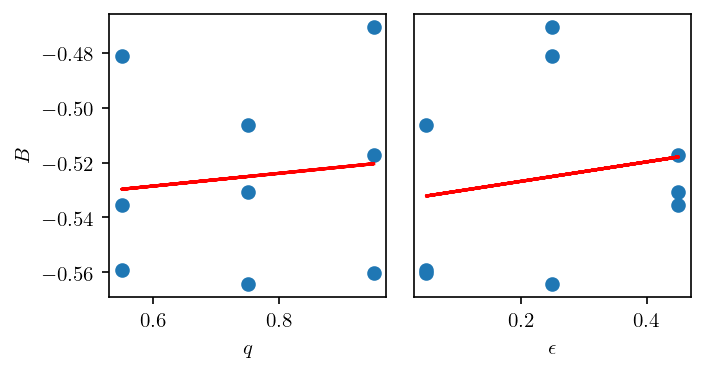

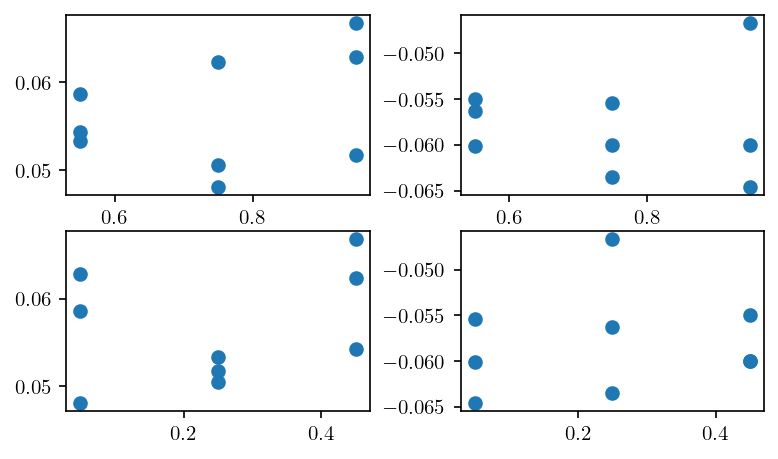

In [295]:
VSK = load('VSK_data_0706.csv')
plot_bursty(VSK)
get_threshold(VSK)

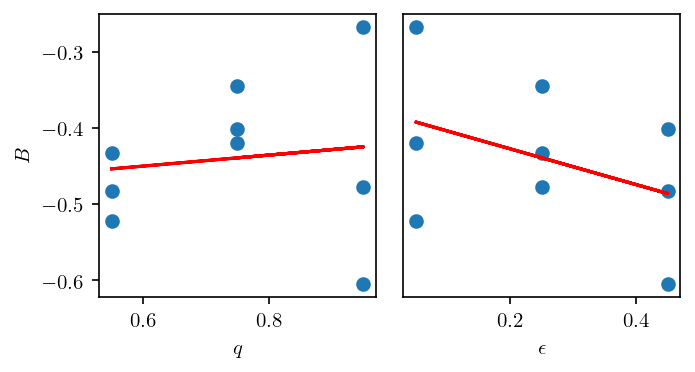

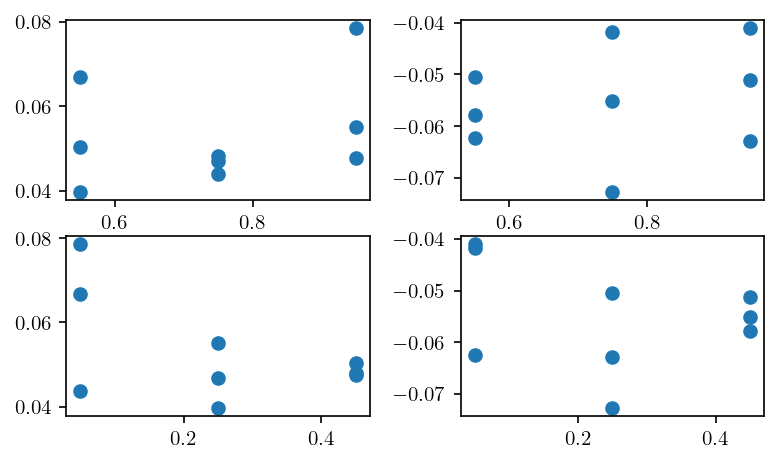

In [296]:
ZA = load('ZA_data_0706.csv')
plot_bursty(ZA)
get_threshold(ZA)

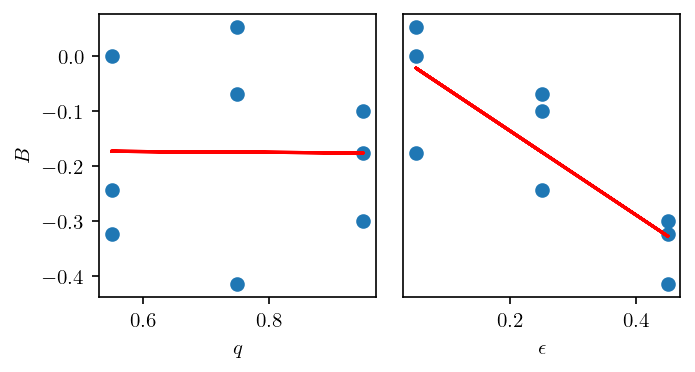

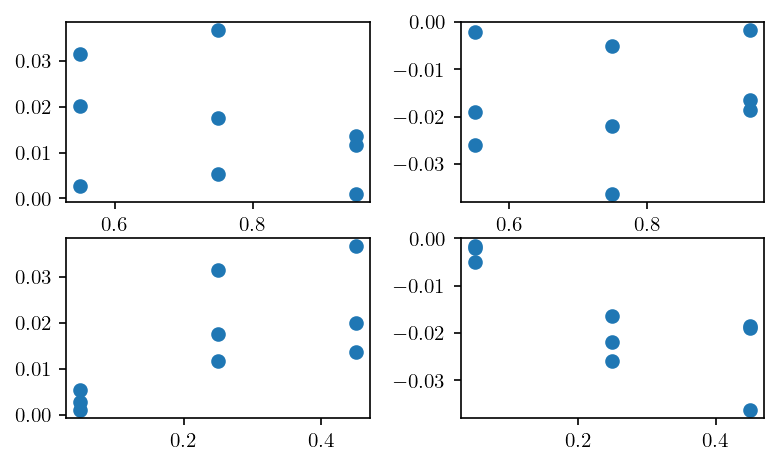

In [297]:
KM = load('KM_data_0706.csv')
plot_bursty(KM)
get_threshold(KM)

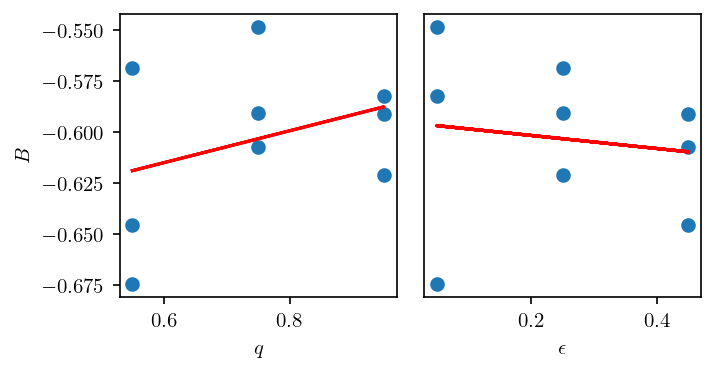

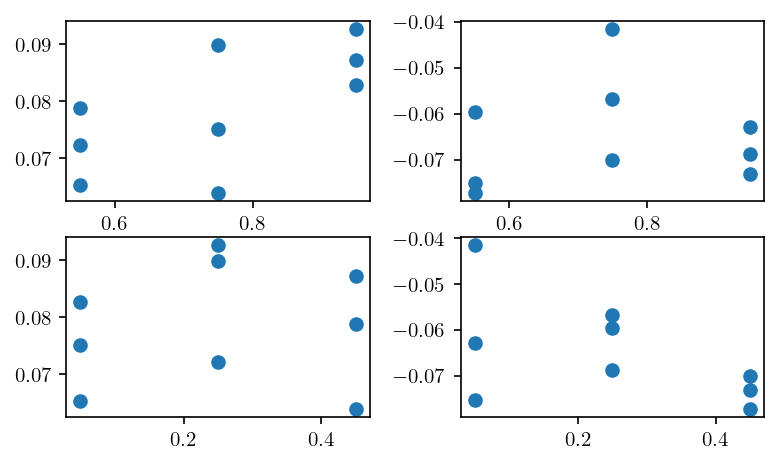

In [298]:
JB = load('JB_data_0707.csv')
plot_bursty(JB)
get_threshold(JB)

In [276]:
JB

,resp.keys,state,q_prob,eps_prob,score,price,resp.rt,steps.thisN,commit
0,0,-1.0,0.55,0.45,0.0,-0.038829,3.871,0.0,0
1,0,-1.0,0.55,0.45,0.0,-0.009062,0.332,1.0,0
2,0,-1.0,0.55,0.45,0.0,-0.008461,0.208,2.0,0
3,0,-1.0,0.55,0.45,0.0,-0.031784,0.202,3.0,0
4,0,-1.0,0.55,0.45,0.0,-0.068134,0.180,4.0,0
...,...,...,...,...,...,...,...,...,...
3460,0,1.0,0.55,0.25,266.0,0.005349,0.322,380.0,0
3461,0,1.0,0.55,0.25,266.0,-0.013623,0.214,381.0,0
3462,0,1.0,0.55,0.25,266.0,-0.034436,0.186,382.0,0
3463,0,1.0,0.55,0.25,266.0,0.001961,0.198,383.0,0


In [187]:
mdl = smf.ols(formula = "commit~q_prob + eps_prob + price", data=JB).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 commit   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2981
Date:                Fri, 07 Jul 2023   Prob (F-statistic):              0.827
Time:                        17:00:50   Log-Likelihood:                -955.63
No. Observations:                3465   AIC:                             1919.
Df Residuals:                    3461   BIC:                             1944.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0965      0.027      3.588      0.000       0.044       0.149
q_prob         0.0240      0.033      0.719      0.472      -0.041       0.089
eps_prob       0.0020      0.033      0.059      0.953      -0.063       0.067
price         -0.0787      0.115     -0.682      0.495      -0.305       0.148
==============================================================================
Omnibus:                     1574.916   Durbin-Watson:                   2.260
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5488.644
Skew:                           2.415   Prob(JB):                         0.00
Kurtosis:                       6.833   Cond. No.                         27.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

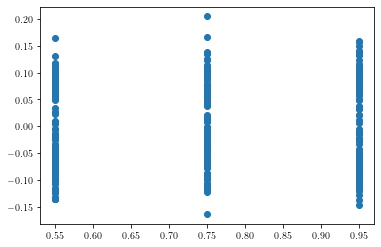

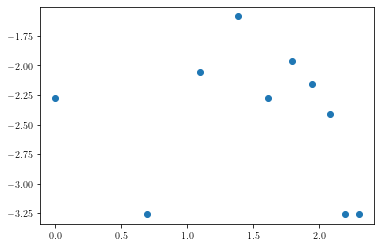

-0.35393924946049216


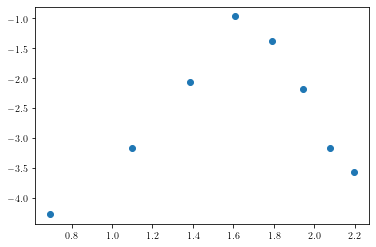

-0.6109556469910532


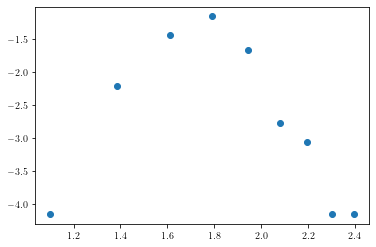

-0.6011854501893626


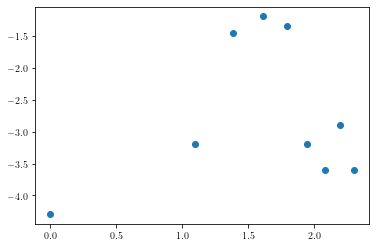

-0.5354245096066971


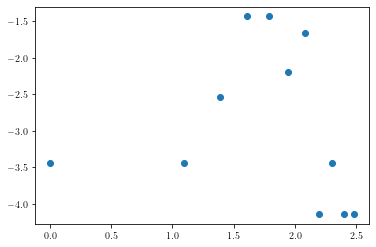

-0.507477775408747


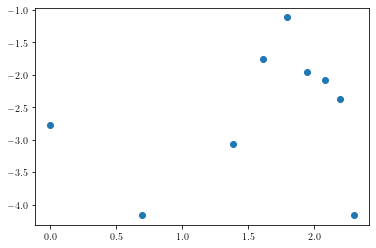

-0.5106070066270242


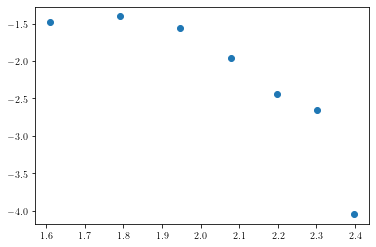

-0.623874782618744


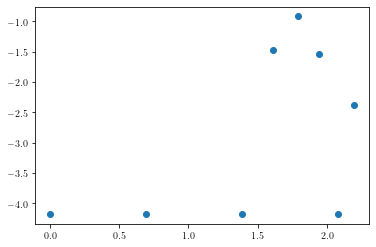

-0.6235548405173343


In [183]:
for i in range(1,9):
    curBlock = block(i,data)
    all_lags, lags, freq, N = convert_to_bursty(np.array(curBlock.commit), 1)
    plt.scatter(np.log(lags), np.log(freq/N))
    plt.show()
    print(compute_burstiness(all_lags))